In [ ]:
https://github.com/OverLordGoldDragon/ssqueezepy

In [ ]:
from abc import ABC, abstractmethod
import torch
import torchaudio.transforms as T
from utils.utils_data import MinMaxScaler, MinMaxArgs


class TsImgEmbedder(ABC):
    """
    Abstract class for transforming time series to images and vice versa
    """

    def __init__(self, device, seq_len):
        self.device = device
        self.seq_len = seq_len

    @abstractmethod
    def ts_to_img(self, signal):
        """

        Args:
            signal: given time series

        Returns:
            image representation of the signal

        """
        pass

    @abstractmethod
    def img_to_ts(self, img):
        """

        Args:
            img: given generated image

        Returns:
            time series representation of the generated image
        """
        pass

In [ ]:
import scipy.io as scio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ssqueezepy import cwt, icwt
from ssqueezepy import Wavelet

class WAVEmbedder(TsImgEmbedder):
    def __init__(self, device, seq_len, nv=8, scales='log-piecewise'):
        super().__init__(device,seq_len)
        
        self.wavelet = Wavelet(('gmw', {'gamma': 3, 'beta': 60, 'norm': 'energy'}))
        self.nv = nv
        self.scales = scales
        self.min_real, self.max_real = None, None
        self.min_imag, self.max_imag = None, None
        self.min_trd, self.max_trd = None, None

        # self.org_img_width = seq_len

        # self.device = device

    def cache_min_max_params(self, train_data):

        real, imag, trd = self.wav_transform(train_data)
        # compute and cache min and max values
        real, min_real, max_real = MinMaxScaler(real, True)
        imag, min_imag, max_imag = MinMaxScaler(imag, True)
        trd, min_trd, max_trd = MinMaxScaler(trd, True)

        self.min_real, self.max_real = torch.Tensor(min_real), torch.Tensor(max_real)
        self.min_imag, self.max_imag = torch.Tensor(min_imag), torch.Tensor(max_imag)
        self.min_trd, self.max_trd = torch.Tensor(min_trd), torch.Tensor(max_trd)

    def wav_transform(self, data):
        """
        Args:
            data: time series data. Shape: (B,L,K)
        Returns:
            real and imaginary part of the continuous wavelet transform 
        """

        signal = data
        t = np.arange(signal.shape[1])

        # print("signal shape", signal[1].shape)

        self.trends = np.empty_like(signal)
        # self.trend_2D = np.meshgrid
        self.detrended_signals = np.empty_like(signal)
        self.trend_2D = np.empty((signal.shape[0], signal.shape[1], signal.shape[1]))

        for i in range(signal.shape[0]):
            trend = np.poly1d(np.polyfit(t, signal[i].squeeze(-1), deg=7))(t)
            trend = trend[:,np.newaxis]
            # print(trend.shape)
            self.trends[i] = trend
            self.detrended_signals[i] = signal[i] - trend

            T, Z = np.meshgrid(t,t)
            trend_2D = np.poly1d(np.polyfit(t, signal[i].squeeze(-1), deg=7))(T)
            self.trend_2D[i] = trend_2D

        self.detrended_signals = self.detrended_signals.squeeze(-1)
        # print("testhh",self.detrended_signals.shape)

        Wx_detrended, self.scales_s = cwt(self.detrended_signals, wavelet=self.wavelet, scales = self.scales,nv=self.nv,l1_norm=False)

        Wx_detrended = Wx_detrended[:,np.newaxis,:,:] #add newaxis on dim1 (21, 1, 227, 728)
        self.trend_2D = self.trend_2D[:,np.newaxis,:,:]
        # print("trend",self.trends.shape)
        # print("trend_2D",self.trend_2D.shape)

        return Wx_detrended.real, Wx_detrended.imag, self.trend_2D

    def ts_to_img(self, signal):
        assert self.min_real is not None, "use init_norm_args() to compute scaling arguments"

        real, imag, trd = self.wav_transform(signal)
        real, imag, trd = torch.Tensor(real).to(self.device), torch.Tensor(imag).to(self.device), torch.Tensor(trd).to(self.device)
        
        # MinMax scaling
        real = (MinMaxArgs(real, self.min_real.to(self.device), self.max_real.to(self.device)) - 0.5) * 2
        imag = (MinMaxArgs(imag, self.min_imag.to(self.device), self.max_imag.to(self.device)) - 0.5) * 2
        trd = (MinMaxArgs(trd, self.min_trd.to(self.device), self.max_trd.to(self.device)) - 0.5) * 2

        #padding on image
        real = self.pad_to_square_wav(real)
        imag = self.pad_to_square_wav(imag)

        wavelet_out = torch.cat((real, imag, trd), dim=1)
        # print("wavelet_out",wavelet_out.shape)

        return wavelet_out

    def img_to_ts(self, x_image):
        
        min_real, max_real = self.min_real.to(self.device), self.max_real.to(self.device)
        min_imag, max_imag = self.min_imag.to(self.device), self.max_imag.to(self.device)
        min_trd, max_trd = self.min_trd.to(self.device), self.max_trd.to(self.device)

        split = torch.split(x_image, x_image.shape[1] // 3, dim=1)
        real, imag, trd = split[0], split[1], split[2]
        
        #unpad of image
        real = self.unpad_wav(real)
        imag = self.unpad_wav(imag)

        unnormalized_real = ((real / 2) + 0.5) * (max_real - min_real) + min_real
        unnormalized_imag = ((imag / 2) + 0.5) * (max_imag - min_imag) + min_imag
        unnormalized_trd  = ((trd / 2)  + 0.5) * (max_trd  - min_trd) + min_trd

        unnormalized_wav = torch.complex(unnormalized_real, unnormalized_imag)

        unnormalized_wav = unnormalized_wav.cpu().numpy()
        unnormalized_trd = unnormalized_trd.cpu().numpy()

        # print("wave",unnormalized_wav.shape)
        # print("tred",unnormalized_trd.shape)

        Wx_detrended = np.squeeze(unnormalized_wav,axis=1) #remove the added axis
        trd_img = np.squeeze(unnormalized_trd,axis=1) #remove the added axis

        reconstructed_detrended = icwt(Wx_detrended, wavelet=self.wavelet, scales = self.scales_s,nv=self.nv,l1_norm=False)

        self.reconstructed_trend = np.empty((trd_img.shape[0],trd_img.shape[1]))

        for i in range(trd_img.shape[0]):
            t = np.arange(trd_img.shape[1])
            trend_values = trd_img[i][0, :]  # Extract the corresponding 1D trend values
            reconstructed_polynomial = np.poly1d(np.polyfit(t, trend_values, deg=7))
            self.reconstructed_trend[i] = reconstructed_polynomial(t)

        # print("final_reconstructed_detrend",reconstructed_detrended.shape)
        # print("final_reconstructed_trend",self.reconstructed_trend.shape)

        reconstructed_with_trend = reconstructed_detrended + self.reconstructed_trend

        return torch.Tensor(reconstructed_with_trend).to(self.device)

    def pad_to_square_wav(self, x_image):
        _, _, height, width = x_image.shape
        height_padding = width - height 
        
        if height_padding > 0:
            # print("pad")
            last_row = x_image[:, :, -1:, :] 
            row_padding_tensor = last_row.repeat(1, 1, height_padding, 1)  
            x_padded_image = torch.cat((x_image, row_padding_tensor), dim=2)  

        else: 
            # print("nopad")
            return x_image

        return x_padded_image

    def unpad_wav(self, x_image):

        org_img_width = self.scales_s.shape[0] #orginal number of scale

        _, _, img_height, img_width = x_image.shape

        if img_width != org_img_width:

            return x_image[: , : , :org_img_width, :]

        return x_image


class WAVEmbedder_ST(TsImgEmbedder):
    def __init__(self, device, seq_len, nv=7, scales='log-piecewise'):
        super().__init__(device,seq_len)

        self.wavelet = Wavelet(('gmw', {'gamma': 3, 'beta': 60, 'norm': 'energy'}))
        self.nv = nv
        self.scales = scales
        self.min_real, self.max_real = None, None
        self.min_imag, self.max_imag = None, None
        self.min_trd, self.max_trd = None, None

        # self.device = device

    def cache_min_max_params(self, train_data):

        real, imag, trd = self.wav_transform(train_data)
        # compute and cache min and max values
        real, min_real, max_real = MinMaxScaler(real, True)
        imag, min_imag, max_imag = MinMaxScaler(imag, True)
        trd, min_trd, max_trd = MinMaxScaler(trd, True)

        self.min_real, self.max_real = torch.Tensor(min_real), torch.Tensor(max_real)
        self.min_imag, self.max_imag = torch.Tensor(min_imag), torch.Tensor(max_imag)
        self.min_trd, self.max_trd = torch.Tensor(min_trd), torch.Tensor(max_trd)

    def wav_transform(self, data):

        signal = data
        t = np.arange(signal.shape[1])

        self.trends = np.empty_like(signal)
        self.detrended_signals = np.empty_like(signal)
        self.trends_2D = np.empty((signal.shape[0], signal.shape[2], signal.shape[1], signal.shape[1]))

        for batch_idx in range(signal.shape[0]):
            for feature_idx in range(signal.shape[2]):
                
                time_series_signal = signal[batch_idx,:,feature_idx]
                trend = np.poly1d(np.polyfit(t, time_series_signal, deg=7))(t)
                
                self.trends[batch_idx, :, feature_idx] = trend

                detrended_signal = time_series_signal - trend
                self.detrended_signals[batch_idx,:,feature_idx] = detrended_signal

                T, Z = np.meshgrid(t,t)
                trend_2D = np.poly1d(np.polyfit(t, time_series_signal, deg=7))(T)
                self.trends_2D[batch_idx,feature_idx,:,:] = trend_2D


        # wavelogram_real = np.empty((signal.shape[0], signal.shape[2], signal.shape[1], signal.shape[1]))
        # wavelogram_imag = np.empty((signal.shape[0], signal.shape[2], signal.shape[1], signal.shape[1]))
        wavelogram_real = []
        wavelogram_imag = []
        
        for feature_wav_idx in range(signal.shape[2]):
            ts_to_wav_signal = self.detrended_signals[:,:,feature_wav_idx]
            Wx_detrended, self.scales_s = cwt(ts_to_wav_signal, wavelet=self.wavelet, scales = self.scales,nv=self.nv,l1_norm=False)
            # print(Wx_detrended.shape)

            # version1
            # wavelogram_real[:,feature_wav_idx,:,:] = Wx_detrended.real
            # wavelogram_imag[:,feature_wav_idx,:,:] = Wx_detrended.imag
            wavelogram_real.append(Wx_detrended.real)
            wavelogram_imag.append(Wx_detrended.imag)

        wavelogram_real = np.array(wavelogram_real)
        wavelogram_imag = np.array(wavelogram_imag)
        wavelogram_real = np.transpose(wavelogram_real, (1, 0, 2, 3))
        wavelogram_imag = np.transpose(wavelogram_imag, (1, 0, 2, 3))

        return wavelogram_real, wavelogram_imag, self.trends_2D

    def ts_to_img(self, signal):
        assert self.min_real is not None, "use init_norm_args() to compute scaling arguments"

        real, imag, trd = self.wav_transform(signal)
        real, imag, trd = torch.Tensor(real).to(self.device), torch.Tensor(imag).to(self.device), torch.Tensor(trd).to(self.device)

        # MinMax scaling
        real = (MinMaxArgs(real, self.min_real.to(self.device), self.max_real.to(self.device)) - 0.5) * 2
        imag = (MinMaxArgs(imag, self.min_imag.to(self.device), self.max_imag.to(self.device)) - 0.5) * 2
        trd = (MinMaxArgs(trd, self.min_trd.to(self.device), self.max_trd.to(self.device)) - 0.5) * 2

        real = self.pad_to_square_wav(real)
        imag = self.pad_to_square_wav(imag)

        # print(real.shape)
        # print(imag.shape)
        # print(trd.shape)
        wavelet_out = torch.cat((real, imag, trd), dim=1)
        # print("wavelet_out",wavelet_out.shape)

        return wavelet_out

    def img_to_ts(self, x_image):
        
        min_real, max_real = self.min_real.to(self.device), self.max_real.to(self.device)
        min_imag, max_imag = self.min_imag.to(self.device), self.max_imag.to(self.device)
        min_trd, max_trd = self.min_trd.to(self.device), self.max_trd.to(self.device)

        split = torch.split(x_image, x_image.shape[1] // 3, dim=1)
        real, imag, trd = split[0], split[1], split[2]

        real = self.unpad_wav(real)
        imag = self.unpad_wav(imag)

        # print("channel",real.shape)
        # print(imag.shape)
        # print(trd.shape)

        unnormalized_real = ((real / 2) + 0.5) * (max_real - min_real) + min_real
        unnormalized_imag = ((imag / 2) + 0.5) * (max_imag - min_imag) + min_imag
        unnormalized_trd  = ((trd / 2)  + 0.5) * (max_trd  - min_trd) + min_trd

        unnormalized_wav = torch.complex(unnormalized_real, unnormalized_imag)

        unnormalized_wav = unnormalized_wav.cpu().numpy()
        unnormalized_trd = unnormalized_trd.cpu().numpy()

        # print("check1",unnormalized_wav.shape)

        self.reconstructed_detrended = np.empty((unnormalized_wav.shape[0],unnormalized_wav.shape[3],unnormalized_wav.shape[1]))

        for ft_iwav_idx in range(unnormalized_wav.shape[1]):
            iwx_detrended = unnormalized_wav[:,ft_iwav_idx,:,:]
            # print("iwx",iwx_detrended.shape)
            reconstructed_detrendeds = icwt(iwx_detrended, wavelet=self.wavelet, scales = self.scales,nv=self.nv,l1_norm=False)
            # print("check",reconstructed_detrendeds.shape)
            self.reconstructed_detrended[:,:,ft_iwav_idx] = reconstructed_detrendeds
            # print("iwt2",reconstructed_detrendeds.shape)

        self.reconstructed_trend = np.empty((unnormalized_trd.shape[0],unnormalized_trd.shape[3],unnormalized_trd.shape[1]))

        for bt_trd_idx in range(unnormalized_trd.shape[0]):
            for ft_trx_idx in range(unnormalized_trd.shape[1]):
                t = np.arange(unnormalized_trd.shape[3])
                # print(t.shape)
                trend_values = unnormalized_trd[bt_trd_idx][ft_trx_idx][0, :]
                # print("checktrend",trend_values.shape)
                reconstructed_polynomial = np.poly1d(np.polyfit(t, trend_values, deg=7))
                # print("rec_trend",reconstructed_polynomial(t).shape)
                self.reconstructed_trend[bt_trd_idx,:,ft_trx_idx] = reconstructed_polynomial(t)

        reconstructed_with_trend = self.reconstructed_detrended + self.reconstructed_trend

        return torch.Tensor(reconstructed_with_trend).to(self.device)
        
    def pad_to_square_wav(self, x_image):
        _, _, height, width = x_image.shape
        height_padding = width - height 
        
        if height_padding > 0:
            # print("pad")
            last_row = x_image[:, :, -1:, :] 
            row_padding_tensor = last_row.repeat(1, 1, height_padding, 1)  
            x_padded_image = torch.cat((x_image, row_padding_tensor), dim=2)  

        else: 
            # print("nopad")
            return x_image

        return x_padded_image

    def unpad_wav(self, x_image):

        org_img_width = self.scales_s.shape[0] #orginal number of scale

        _, _, img_height, img_width = x_image.shape

        if img_width != org_img_width:

            return x_image[: , : , :org_img_width, :]

        return x_image

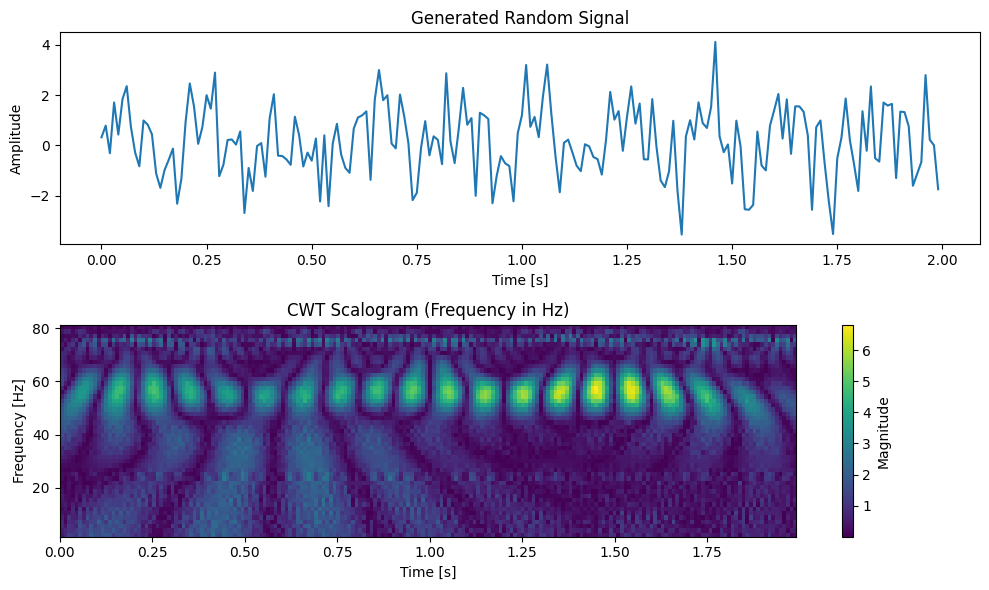

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Parameters
fs = 100  # Sampling frequency in Hz
t = np.linspace(0, 2, fs * 2, endpoint=False)  # 2 seconds of data
signal = np.random.randn(len(t))  # Random signal

# Add some known frequency components for clarity
signal += np.sin(2 * np.pi * 5 * t)  # 5 Hz sine
signal += np.sin(2 * np.pi * 20 * t)  # 20 Hz sine

# CWT parameters
wavelet = 'cmor1.5-1.0'  # Complex Morlet wavelet
scales = np.arange(1, 50)

# Perform CWT
coefficients, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)

# Plot
plt.figure(figsize=(10, 6))

# Time series
plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title("Generated Random Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

# CWT scalogram
plt.subplot(2, 1, 2)
plt.imshow(np.abs(coefficients), extent=[t[0], t[-1], freqs[-1], freqs[0]],
           cmap='viridis', aspect='auto')
plt.title("CWT Scalogram (Frequency in Hz)")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label="Magnitude")

plt.tight_layout()
plt.show()

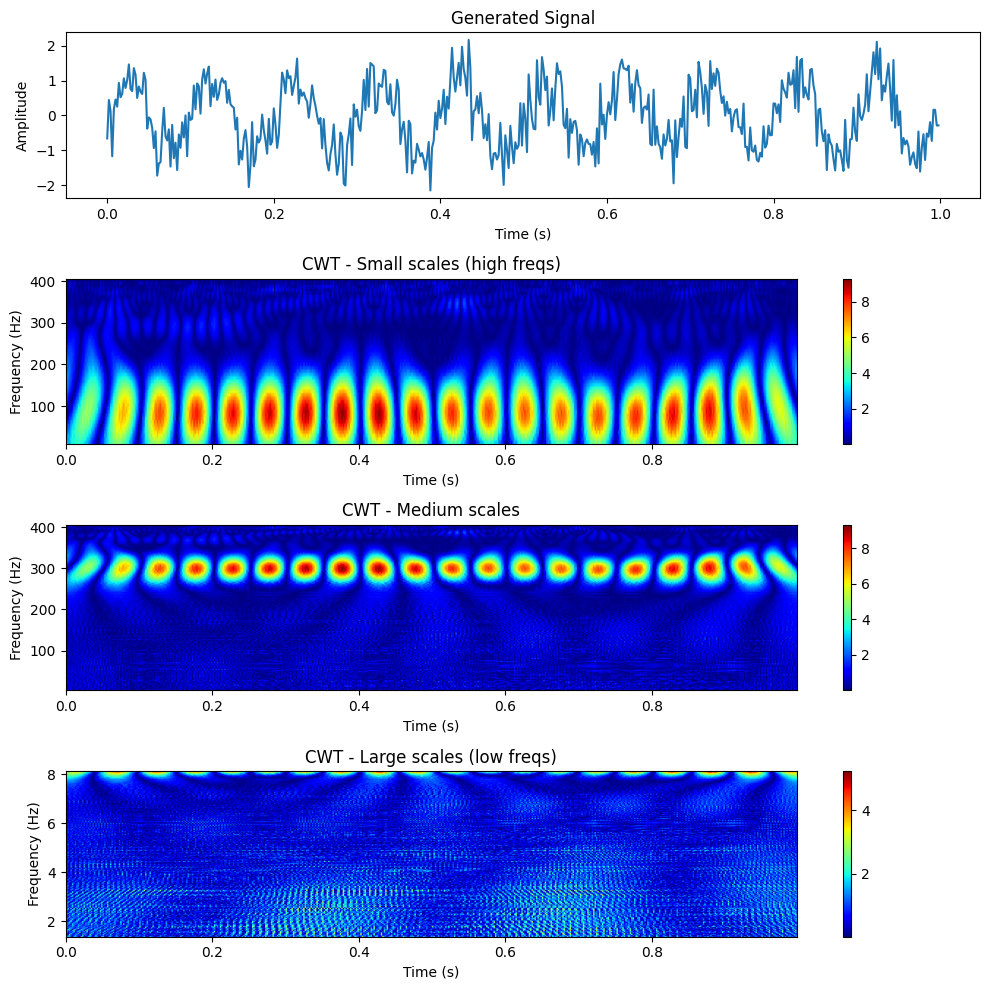

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Generate a random signal
fs = 500  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 10 * t) + 0.5 * np.random.randn(len(t))

# Different scale configurations for different y-axis ranges
scale_sets = {
    "Small scales (high freqs)": np.arange(1, 50),
    "Medium scales": np.arange(1, 150),
    "Large scales (low freqs)": np.arange(50, 300)
}

# Create subplots
fig, axes = plt.subplots(len(scale_sets) + 1, 1, figsize=(10, 10))

# Plot the signal
axes[0].plot(t, signal)
axes[0].set_title("Generated Signal")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")

# Apply CWT with different scales
for i, (label, scales) in enumerate(scale_sets.items(), start=1):
    coeffs, freqs = pywt.cwt(signal, scales, 'morl', sampling_period=1/fs)
    im = axes[i].imshow(np.abs(coeffs), extent=[t[0], t[-1], freqs[-1], freqs[0]],
                        cmap='jet', aspect='auto')
    axes[i].set_title(f"CWT - {label}")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Frequency (Hz)")
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

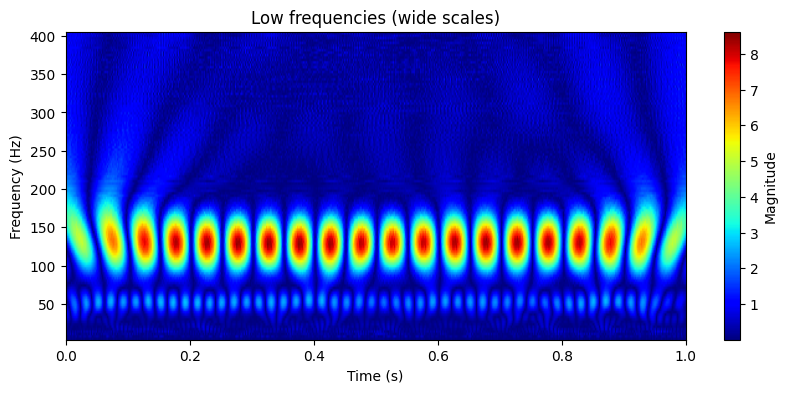

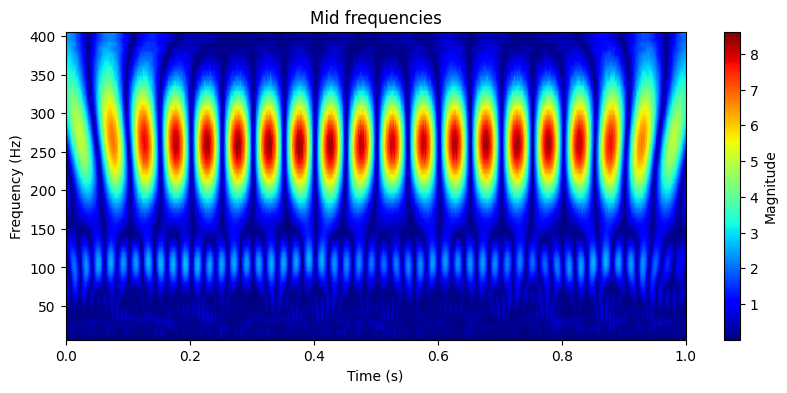

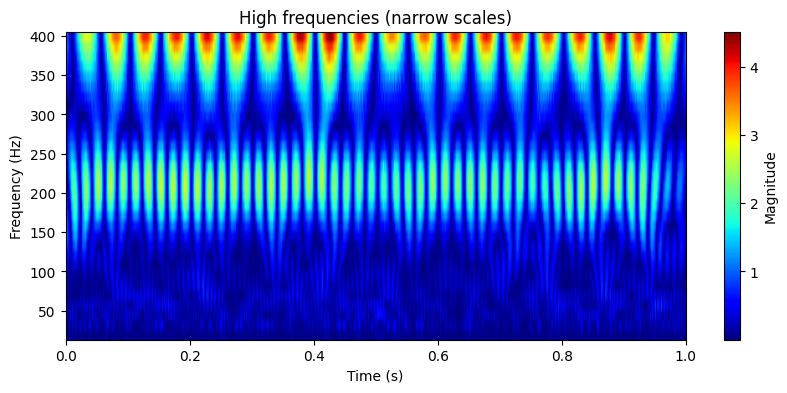

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Generate a random signal
np.random.seed(42)
time = np.linspace(0, 1, 500)  # 1 second, 500 samples
signal = np.sin(20 * np.pi * time) + 0.5 * np.sin(50 * np.pi * time) + 0.3 * np.random.randn(len(time))

# Function to perform CWT and plot
def plot_cwt_with_scales(signal, time, scales, title):
    coefficients, frequencies = pywt.cwt(signal, scales, 'morl', sampling_period=time[1] - time[0])
    
    plt.figure(figsize=(10, 4))
    plt.imshow(np.abs(coefficients), extent=[time.min(), time.max(), frequencies.min(), frequencies.max()],
               cmap='jet', aspect='auto', origin='lower')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.show()

# Try different frequency parameters by changing the scales
scale_sets = {
    "Low frequencies (wide scales)": np.arange(1, 128),
    "Mid frequencies": np.arange(1, 64),
    "High frequencies (narrow scales)": np.arange(1, 32)
}

for title, scales in scale_sets.items():
    plot_cwt_with_scales(signal, time, scales, title)